In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set random seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Load your dataset
data = pd.read_csv(r"C:\Users\Sasi Kanth\Desktop\SolarPower\SolcastData\Data17_Filtered.csv")

# Retain the 'period_end' column for tracking timestamps
timestamps = data['period_end'].values

# Drop unnecessary columns (you can drop 'period' but retain 'period_end')
data = data.drop(columns=['period'])

# Separate the target column 'gti' and features
target_column = 'gti'
X_data = data.drop(columns=[target_column, 'period_end'])
y_data = data[target_column]

# Feature scaling for features and target
scaler_X = MinMaxScaler()
scaled_X = scaler_X.fit_transform(X_data)

scaler_y = MinMaxScaler()
scaled_y = scaler_y.fit_transform(y_data.values.reshape(-1, 1))

# Create sequences and labels for LSTM with a skip pattern (15-min interval)
def create_sequences(X, y, sequence_length):
    sequences_X = []
    sequences_y = []
    for i in range(0, len(X) - sequence_length * 3, 3):  # Step by 3 to skip 2 rows (15-min interval)
        sequences_X.append(X[i:i + sequence_length])  # 8 time steps, each 15 minutes apart
        sequences_y.append(y[i + sequence_length])    # Target at the end of sequence
    return np.array(sequences_X), np.array(sequences_y)

# Set sequence length for 2 hours (8 * 15-minute intervals)
sequence_length = 8
X, y = create_sequences(scaled_X, scaled_y, sequence_length)

# Adjust the timestamps for the sequences (remove the first 'sequence_length' entries)
timestamps = timestamps[sequence_length * 3:]  # Skip the first few rows based on sequence length and skipping

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X_data.shape[1]))

# Split into training and testing datasets
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Also split the timestamps to align with test data
timestamps_train, timestamps_test = timestamps[:split], timestamps[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1))  # Output layer for 'gti' prediction

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Predictions
predictions = model.predict(X_test)

# Inverse transform predictions
predictions = scaler_y.inverse_transform(predictions)

# Save the model and weights
model.save('solar_model_17_min15.h5')
model.save_weights('solar_model_17_min15.weights.h5')


Epoch 1/20


c:\Users\Sasi Kanth\anaconda3\envs\rengoku\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3391/3391 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0055 - val_loss: 4.9156e-04
Epoch 2/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0011 - val_loss: 3.4587e-04
Epoch 3/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 8.7702e-04 - val_loss: 3.8693e-04
Epoch 4/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 8.2388e-04 - val_loss: 3.3348e-04
Epoch 5/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 7.8663e-04 - val_loss: 3.4501e-04
Epoch 6/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 7.4825e-04 - val_loss: 3.7830e-04
Epoch 7/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 7.3700e-04 - val_loss: 5.4515e-04
Epoch 8/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 7.2176e-04 - val_loss: 3.9717e-04
Epoch 9/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 7.1411e-04 - val_loss: 4.1407e-04
Epoch 10/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 7.0366e-04 - val_loss: 3.5756e-04
Epoch 11/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 21s 6

In [3]:
# Inverse transform the predictions and actual values to get the original scale
predictions = scaler_y.inverse_transform(predictions)
actual_values = scaler_y.inverse_transform(y_test)

# Calculate absolute errors
errors = np.abs(predictions - actual_values)

# Find the indices of the max and min errors
max_error_idx = np.argmax(errors)
min_error_idx = np.argmin(errors)

# Retrieve max and min errors and their corresponding predicted, actual values, and timestamps
max_error = errors[max_error_idx]
min_error = errors[min_error_idx]

max_error_predicted = predictions[max_error_idx][0]
max_error_actual = actual_values[max_error_idx][0]
max_error_time = timestamps_test[max_error_idx]

min_error_predicted = predictions[min_error_idx][0]
min_error_actual = actual_values[min_error_idx][0]
min_error_time = timestamps_test[min_error_idx]

# Print the results
print(f"Maximum Error: {max_error}")
print(f"Predicted Value (Max Error): {max_error_predicted}, Actual Value (Max Error): {max_error_actual}")
print(f"Timestamp (Max Error): {max_error_time}")

print(f"Minimum Error: {min_error}")
print(f"Predicted Value (Min Error): {min_error_predicted}, Actual Value (Min Error): {min_error_actual}")
print(f"Timestamp (Min Error): {min_error_time}")

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print(f"Test MSE: {mse}")

Maximum Error: [1.4159674e+09]
Predicted Value (Max Error): 1415968512.0, Actual Value (Max Error): 1109.0
Timestamp (Max Error): 2012-09-21 17:35:00+04:00
Minimum Error: [44.26974869]
Predicted Value (Min Error): 44.26974868774414, Actual Value (Min Error): 0.0
Timestamp (Min Error): 2011-09-16 07:30:00+04:00
2907/2907 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1.8071e-04
Test MSE: 0.0003455944824963808


In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Assuming `scalerx` is used for feature scaling and `scalery` is used for target scaling
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions using scalery
predictions = scaler_y.inverse_transform(predictions)

# Inverse transform the actual values (y_test) using scalery
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverse, predictions)
print(f"Mean Absolute Error: {mae}")




2907/2907 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Mean Absolute Error: 10.964177963862006


In [5]:
from sklearn.metrics import r2_score

# Calculate R² Score
r2 = r2_score(scaler_y.inverse_transform(y_test.reshape(-1, 1)), predictions)
print(f"Test R² Score: {r2}")


Test R² Score: 0.9957700242649036


In [6]:
# Inverse transform the true test labels (y_test) to original scale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Avoid division by zero by filtering out zero values in the actual test set
non_zero_indices = y_test_original != 0

# Calculate the errors (difference between actual and predicted values) for non-zero actual values
errors_percentage = np.abs((y_test_original[non_zero_indices] - predictions[non_zero_indices]) / y_test_original[non_zero_indices]) * 100

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(errors_percentage)

print(f"Total Error Percentage (MAPE): {mape:.2f}%")


Total Error Percentage (MAPE): 7.56%


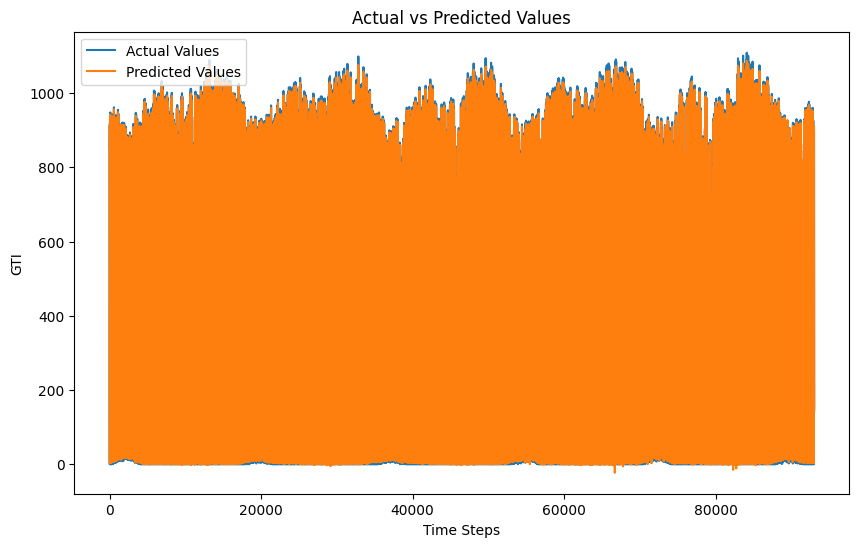

In [7]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(scaler_y.inverse_transform(y_test.reshape(-1, 1)), label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('GTI')
plt.legend()
plt.show()


In [8]:
predictions

array([[908.41925],
       [883.9458 ],
       [853.3179 ],
       ...,
       [239.47882],
       [201.35156],
       [151.33908]], dtype=float32)

In [9]:
X_test.shape, y_test.shape,predictions.shape

((92993, 8, 13), (92993, 1), (92993, 1))

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load your dataset
data = pd.read_csv(r"C:\Users\Sasi Kanth\Desktop\SolarPower\SolcastData\Data17_Filtered.csv")

# Retain the 'period_end' column for tracking timestamps
timestamps = data['period_end'].values

# Drop unnecessary columns (keep 'period_end', drop 'period')
data = data.drop(columns=['period'])

# Separate the target column 'gti' and features
target_column = 'gti'
X_data = data.drop(columns=[target_column, 'period_end'])
y_data = data[target_column]

# Feature scaling for features and target
scaler_X = MinMaxScaler()
scaled_X = scaler_X.fit_transform(X_data)

scaler_y = MinMaxScaler()
scaled_y = scaler_y.fit_transform(y_data.values.reshape(-1, 1))

# Function to create sequences
def create_sequences(X, y, sequence_length):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - sequence_length):
        sequences_X.append(X[i:i + sequence_length])
        sequences_y.append(y[i + sequence_length])
    return np.array(sequences_X), np.array(sequences_y)

sequence_length = 24  # Assuming 2 hours (24 * 5-minute intervals)
X, y = create_sequences(scaled_X, scaled_y, sequence_length)

# Adjust timestamps to remove first 'sequence_length' entries
timestamps = timestamps[sequence_length:]

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X_data.shape[1]))

# Split into training and testing datasets
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Also split the timestamps to align with test data
timestamps_train, timestamps_test = timestamps[:split], timestamps[split:]

# Load your saved model
model = load_model('solar_model_17.h5')

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions back to the original scale
predictions_original_scale = scaler_y.inverse_transform(predictions)

# Inverse transform the true y_test values to their original scale
y_test_original_scale = scaler_y.inverse_transform(y_test)

# Extract the corresponding part of the original dataset for the test split
original_test_data = data.iloc[split + sequence_length:].copy()

# Add the predictions to the original test dataset
original_test_data['predicted_gti'] = predictions_original_scale

# Optionally, add the true values for comparison
original_test_data['true_gti'] = y_test_original_scale

# Save the dataset with the predictions
output_path = r"C:\Users\Sasi Kanth\Desktop\SolarPower\Min15TestDatasetWithPredictions.csv"
original_test_data.to_csv(output_path, index=False)

print(f"Test dataset with predictions saved to: {output_path}")


8719/8719 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step
Test dataset with predictions saved to: C:\Users\Sasi Kanth\Desktop\SolarPower\Min15TestDatasetWithPredictions.csv


In [11]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("TestDatasetWithPredictions.csv")

# Convert 'period_end' to datetime and remove any timezone information
df['period_end'] = pd.to_datetime(df['period_end']).dt.tz_localize(None)

# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['period_end', 'average_actual_gti', 'average_predicted_gti'])

# Define the window parameters (2-hour averaging with 1-hour sliding window)
window_size = pd.Timedelta(hours=2)
step_size = pd.Timedelta(hours=1)

# Function to calculate window averages for a given day's data
def calculate_daily_windows(daily_data, start_time):
    global result_df
    while start_time + window_size <= daily_data['period_end'].max():
        # Define the end time for the window
        end_time = start_time + window_size

        # Filter the data within this window
        window_data = daily_data[(daily_data['period_end'] >= start_time) & (daily_data['period_end'] < end_time)]

        # Calculate the average actual and predicted GTI values
        avg_actual_gti = window_data['true_gti'].mean()  # Replace with the correct column name
        avg_predicted_gti = window_data['predicted_gti'].mean()  # Replace with the correct column name

        # Create a DataFrame for the current window's averages
        row_df = pd.DataFrame({
            'period_end': [start_time],
            'average_actual_gti': [avg_actual_gti],
            'average_predicted_gti': [avg_predicted_gti]
        })

        # Concatenate the new row to the result DataFrame
        result_df = pd.concat([result_df, row_df], ignore_index=True)

        # Move the window forward by 1 hour
        start_time += step_size

# Process the first day's data starting from the first available time
first_day = df['period_end'].dt.date.min()
first_day_data = df[df['period_end'].dt.date == first_day]

# Get the first row's time as the starting point
start_time = first_day_data['period_end'].min()

# Calculate windows for the first day
calculate_daily_windows(first_day_data, start_time)

# Process each subsequent day, starting from 6 AM
for date in pd.date_range(start=first_day + pd.Timedelta(days=1), end=df['period_end'].dt.date.max(), freq='D'):
    # Get the data for the current day
    daily_data = df[df['period_end'].dt.date == date.date()]
    
    if daily_data.empty:
        continue  # Skip if no data for that day

    # Define the starting time for the day (6 AM)
    start_time = pd.Timestamp(date.date()) + pd.Timedelta(hours=6)

    # Only include data between 6 AM and 6 PM
    daily_data = daily_data[(daily_data['period_end'].dt.hour >= 6) & (daily_data['period_end'].dt.hour <= 18)]
    
    # Calculate windows for this day
    calculate_daily_windows(daily_data, start_time)

# Save the result to a CSV file
output_path = r'C:\Users\Sasi Kanth\Desktop\SolarPower\Min15_GTI_AVERAGE.csv'
result_df.to_csv(output_path, index=False)

output_path


C:\Users\Sasi Kanth\AppData\Local\Temp\ipykernel_48552\894618290.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, row_df], ignore_index=True)


'C:\\Users\\Sasi Kanth\\Desktop\\SolarPower\\Min15_GTI_AVERAGE.csv'

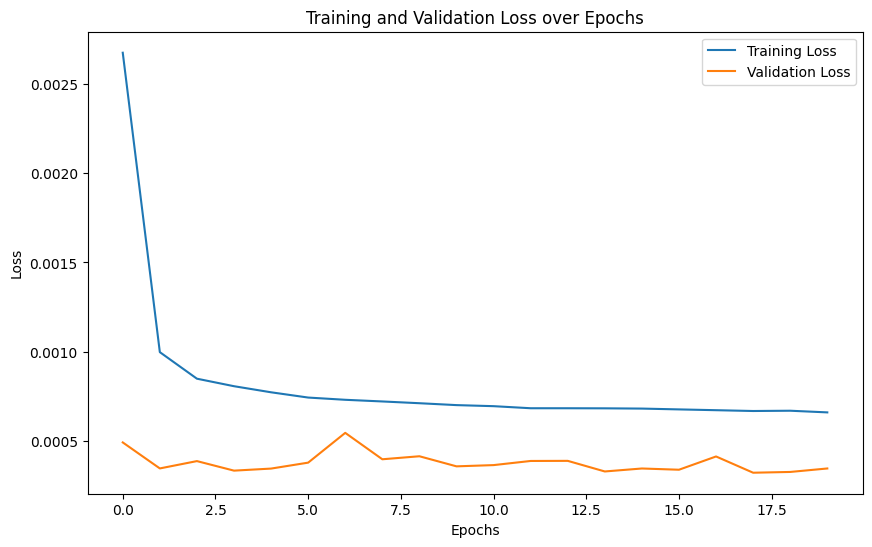

In [12]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.grid(True)
plt.show()
